In [1]:
!nvidia-smi

Thu Apr 11 21:45:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gener...    On | 00000000:01:00.0 Off |                  Off |
| 30%   38C    P2              297W / 300W|  19505MiB / 49140MiB |     62%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from src.segmentation.framework_handlers import yolo_handler
yolo_handler.validate_version_and_gpu()

Ultralytics YOLOv8.1.46 🚀 Python-3.10.0 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
Setup complete ✅ (64 CPUs, 503.6 GB RAM, 12.9/799.6 GB disk)


### Prepare Dataset
In this section, the dataset along with YOLO annotations is processed to conform to the input structure required by YOLO. The YOLO format necessitates organizing the dataset into two main directories, `images` and `labels`. Each of these directories is further divided into two subdirectories, `train` and `val`, for training and validation datasets respectively. This structure facilitates YOLO's training and validation processes.

In [ ]:
# prepare data to fine tune yolo v8
from src.segmentation.framework_handlers.yolo_handler import prepare_data_for_yolo
annotations_folder_name = "etaylor_cannabis_patches_test"
dataset_version = "v0.1"
saving_yaml_path = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO"
yaml_file_path = prepare_data_for_yolo(annotations_folder_name, dataset_version, saving_yaml_path, train_percentage=0.8)

Annotations /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/export_coco-instance_etaylor_cannabis_patches_test_v0.1.json:  53%|█████▎    | 47/89 [00:00<00:00, 465.70it/s]

Annotations /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/export_coco-instance_etaylor_cannabis_patches_test_v0.1.json: 100%|██████████| 89/89 [00:00<00:00, 479.47it/s]

COCO data converted successfully.
Results saved to /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo


The folder /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo has been deleted.


### Ultralytics Settings

In here we can modify the settings of the yolo runs. 

In [3]:
from ultralytics import settings

runs_dir = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs"
# Update a setting
settings.update({'runs_dir': runs_dir})

# View all settings
print(settings)

{'settings_version': '0.0.4', 'datasets_dir': '/sise/home/etaylor/datasets', 'weights_dir': '/home/etaylor/weights', 'runs_dir': '/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs', 'uuid': '3eabad9ed9f85e3e726c43f30dfeac36b9c8e6cecf6546d5abc3435b89c57f67', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': True, 'tensorboard': True, 'wandb': True}


In [4]:
# in case dataset already converted from coco to yolo format use manual path
yaml_file_path = "/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_test_v0.1_data.yaml"

### Find best Hyper params with [Ray Tune](https://docs.ultralytics.com/integrations/ray-tune/#custom-search-space-example)

In the provided code snippet, Ray Tune is utilized for hyperparameter tuning of a YOLOv8n segmentation model using a specific model checkpoint and dataset defined in a YAML file.

In [5]:
from ultralytics import YOLO

model_checkpoint_path = 'yolov9c.pt'
model = YOLO(model_checkpoint_path) # pass any model type

# Start tuning hyperparameters for YOLOv8n training on the COCO8 dataset
result_grid = model.tune(data=yaml_file_path)

Tuner: Initialized Tuner instance with 'tune_dir=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
New https://pypi.org/project/ultralytics/8.1.47 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.46 🚀 Python-3.10.0 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etay

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/train.cache... 73 images, 70 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/val.cache... 16 images, 20 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]


Plotting labels to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.4G      1.913      4.366      1.558        104        640: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


                   all         36        167      0.141      0.408      0.162     0.0878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.6G      1.409      2.426      1.234        308        640: 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


                   all         36        167     0.0735      0.221     0.0816     0.0537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.7G      1.254      1.606      1.142        174        640: 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


                   all         36        167     0.0154      0.576     0.0153     0.0102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.2G      1.245       1.62      1.175        256        640: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


                   all         36        167     0.0171      0.674     0.0166    0.00991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.7G       1.25      1.419      1.148        203        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


                   all         36        167     0.0814      0.346     0.0459     0.0272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.6G      1.252      1.365      1.171        184        640: 100%|██████████| 9/9 [00:01<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


                   all         36        167     0.0162      0.492     0.0127    0.00822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.6G       1.34       1.55      1.164        174        640: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


                   all         36        167      0.186      0.386      0.163      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.7G      1.258      1.329      1.188        173        640: 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


                   all         36        167      0.146      0.157      0.119     0.0767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.6G      1.232      1.373      1.159        166        640: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


                   all         36        167      0.206      0.467      0.183     0.0876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      11.6G       1.28      1.404      1.207        205        640: 100%|██████████| 9/9 [00:01<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


                   all         36        167      0.362      0.528      0.374      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      11.7G      1.212      1.235      1.126        188        640: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


                   all         36        167      0.466      0.458       0.42      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.4G      1.254      1.328      1.192        263        640: 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


                   all         36        167      0.333      0.598      0.417      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      11.6G      1.324      1.256      1.173        130        640: 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


                   all         36        167      0.336      0.606      0.422      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      11.4G      1.262      1.215      1.157        205        640: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]


                   all         36        167      0.323      0.624       0.45      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      11.4G      1.333      1.366      1.187         96        640: 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


                   all         36        167      0.448      0.402      0.398      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.4G      1.279      1.394       1.17        149        640: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


                   all         36        167      0.378      0.432       0.37      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.4G      1.183      1.207       1.15        140        640: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


                   all         36        167      0.712      0.306      0.367      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      11.6G      1.205       1.28      1.122        265        640: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.79it/s]


                   all         36        167      0.674      0.206      0.311      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.4G      1.233      1.241       1.13        171        640: 100%|██████████| 9/9 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


                   all         36        167        0.3       0.42      0.325      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      11.3G      1.171      1.324      1.137        208        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


                   all         36        167      0.378      0.454      0.423      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.3G      1.187      1.234      1.105        134        640: 100%|██████████| 9/9 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


                   all         36        167      0.262       0.68      0.454      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.4G      1.189       1.24      1.114        148        640: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


                   all         36        167      0.466      0.617      0.534      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.3G      1.141      1.199      1.091        224        640: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]


                   all         36        167       0.47      0.575      0.463      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      11.4G       1.14       1.15      1.081        186        640: 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


                   all         36        167      0.436      0.463       0.45      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      11.7G      1.138      1.105      1.111        231        640: 100%|██████████| 9/9 [00:01<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


                   all         36        167       0.44      0.521      0.492      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.3G      1.113      1.117      1.116        231        640: 100%|██████████| 9/9 [00:02<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


                   all         36        167      0.439      0.509      0.495      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.4G      1.088      1.001       1.09        232        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.73it/s]


                   all         36        167      0.408      0.615       0.51      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.3G      1.116      1.028      1.113        127        640: 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


                   all         36        167      0.482      0.589      0.565      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.7G       1.09      1.072      1.085        130        640: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]


                   all         36        167      0.446      0.633      0.513      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      11.7G       1.09      1.045      1.088        218        640: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


                   all         36        167        0.5      0.453      0.449      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.4G      1.069          1      1.061        112        640: 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


                   all         36        167      0.543      0.414      0.459      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      11.4G      1.067      1.055      1.095        159        640: 100%|██████████| 9/9 [00:01<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.79it/s]


                   all         36        167      0.473      0.554      0.528      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.3G       1.12      1.074      1.105        240        640: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


                   all         36        167      0.516      0.607      0.587      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      11.3G      1.095      1.023      1.056        195        640: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]


                   all         36        167      0.405      0.651      0.552      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      11.3G      1.111      1.034      1.084        225        640: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


                   all         36        167      0.631      0.467      0.561      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      11.3G       1.09      1.099      1.109        128        640: 100%|██████████| 9/9 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.23it/s]


                   all         36        167      0.501      0.575      0.539       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      11.3G       1.03     0.9463      1.082        209        640: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]


                   all         36        167      0.506      0.533      0.526      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      11.3G      1.053     0.9796      1.073        177        640: 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


                   all         36        167      0.519      0.574      0.534      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      11.3G      1.055     0.9858       1.06        296        640: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]


                   all         36        167      0.584      0.474      0.555      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      11.4G      1.167       1.14       1.14        252        640: 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


                   all         36        167        0.5      0.476      0.501      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      11.6G      1.079     0.9978      1.064        269        640: 100%|██████████| 9/9 [00:01<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.44it/s]


                   all         36        167      0.502      0.619      0.559      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      11.5G      1.064     0.9606      1.062        195        640: 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


                   all         36        167      0.538      0.513      0.551      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      11.3G      1.062     0.9755      1.071        189        640: 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


                   all         36        167       0.44      0.585      0.514      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      11.3G      1.039      1.115      1.069        147        640: 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


                   all         36        167      0.584      0.517      0.535      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      11.6G      1.006     0.9863      1.077        179        640: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


                   all         36        167      0.462      0.538      0.514      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      11.4G      1.021     0.9843      1.062         88        640: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


                   all         36        167      0.509      0.608      0.558      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.2G      1.047     0.9879      1.045        142        640: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


                   all         36        167      0.611       0.47      0.528      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      11.3G      1.032     0.9388      1.053        198        640: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


                   all         36        167      0.549      0.469      0.508      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      11.2G      1.003     0.9383      1.061        140        640: 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


                   all         36        167      0.485      0.518      0.507      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      11.7G     0.9659     0.8773      1.026        155        640: 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


                   all         36        167      0.447      0.694      0.541      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      11.7G     0.9841     0.8644      1.041        143        640: 100%|██████████| 9/9 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


                   all         36        167      0.619      0.467      0.554      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      11.6G      1.025     0.8885      1.055        188        640: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


                   all         36        167      0.548      0.543       0.56       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      11.7G      1.027     0.9206      1.041        115        640: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


                   all         36        167      0.549      0.588      0.588      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      11.4G     0.9777     0.8304      1.041        221        640: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


                   all         36        167      0.605      0.521      0.585       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      11.5G     0.9728     0.8138      1.031        206        640: 100%|██████████| 9/9 [00:01<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


                   all         36        167      0.565      0.506      0.541       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      11.4G     0.9672     0.7969      1.035        157        640: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


                   all         36        167      0.575      0.519      0.538      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      11.7G     0.9718     0.8014      1.027        167        640: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.14it/s]


                   all         36        167      0.457      0.688      0.591      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      11.3G     0.9602     0.7859      1.016        201        640: 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


                   all         36        167      0.471      0.631      0.605      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      11.3G     0.9772     0.8232      1.033        199        640: 100%|██████████| 9/9 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.64it/s]


                   all         36        167      0.755      0.401      0.576      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      11.4G     0.9445     0.8251      1.018        235        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


                   all         36        167      0.497      0.659      0.579      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      11.7G     0.9294     0.7832      1.018        203        640: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


                   all         36        167      0.479       0.64      0.579      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      11.3G     0.9268     0.7559     0.9942        246        640: 100%|██████████| 9/9 [00:01<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


                   all         36        167      0.489       0.65       0.57      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      11.4G     0.9499     0.7722      1.041        126        640: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.65it/s]


                   all         36        167      0.541       0.56      0.586      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      11.4G     0.9511     0.7583      1.022        159        640: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


                   all         36        167      0.494      0.631      0.544      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      11.2G     0.9238      0.771      1.028        186        640: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


                   all         36        167      0.426      0.627      0.537      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      11.4G     0.9527     0.7538      1.014        190        640: 100%|██████████| 9/9 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.98it/s]


                   all         36        167      0.516      0.537      0.564      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      11.3G     0.8804     0.7133     0.9877        209        640: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


                   all         36        167       0.44        0.6      0.546      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      11.3G     0.9288     0.7717      1.013        173        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.33it/s]


                   all         36        167      0.486      0.483      0.519      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      11.6G     0.8972     0.7267      1.022        155        640: 100%|██████████| 9/9 [00:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


                   all         36        167      0.511      0.467      0.491      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      11.4G      0.905     0.7035      1.004        128        640: 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


                   all         36        167      0.519       0.53      0.519      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      11.3G     0.8546     0.6618     0.9745        242        640: 100%|██████████| 9/9 [00:01<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]


                   all         36        167      0.516      0.564      0.564      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      11.4G     0.8744      0.668     0.9923        149        640: 100%|██████████| 9/9 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]


                   all         36        167      0.528      0.593      0.583      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      11.7G     0.8905     0.7058     0.9813        219        640: 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.29it/s]


                   all         36        167      0.652      0.519      0.602      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      11.6G      0.883     0.6968      1.004        223        640: 100%|██████████| 9/9 [00:02<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]


                   all         36        167      0.492      0.656       0.57       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      11.3G     0.8565     0.7417      0.976        139        640: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


                   all         36        167      0.476      0.639       0.58      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      11.4G     0.8973     0.7512      1.007        148        640: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


                   all         36        167      0.457      0.684      0.571      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      11.6G     0.8743      0.671     0.9978        186        640: 100%|██████████| 9/9 [00:02<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]


                   all         36        167      0.586      0.487      0.555      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      11.4G     0.8821     0.6751     0.9919        211        640: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.10it/s]


                   all         36        167      0.513      0.572      0.557      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      11.3G     0.8445     0.6433     0.9715        132        640: 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


                   all         36        167      0.449      0.623      0.574      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      11.4G     0.8441     0.6296      0.969        162        640: 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.86it/s]


                   all         36        167      0.424      0.666      0.573        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      11.7G      0.836     0.6302     0.9681        201        640: 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]


                   all         36        167      0.557      0.497      0.585      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      11.4G     0.8143     0.5709     0.9674        209        640: 100%|██████████| 9/9 [00:02<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


                   all         36        167      0.517      0.571      0.585       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      11.4G     0.8113     0.5724     0.9625        196        640: 100%|██████████| 9/9 [00:01<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


                   all         36        167      0.567      0.524      0.552      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      11.4G     0.8236     0.6117     0.9872        223        640: 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


                   all         36        167      0.449      0.604      0.542      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      11.6G     0.7961     0.5726     0.9634        241        640: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.66it/s]


                   all         36        167      0.461      0.592      0.556      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      11.3G     0.8219     0.5698     0.9833        167        640: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


                   all         36        167      0.471      0.602      0.581      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.3G     0.7924     0.5302     0.9637        159        640: 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


                   all         36        167      0.493      0.549      0.562       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      11.4G     0.8082     0.5984     0.9603        279        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


                   all         36        167      0.508      0.537      0.533      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      11.6G     0.8303     0.5534     0.9783        229        640: 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


                   all         36        167       0.51      0.528      0.524      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      11.4G     0.8011     0.5377      0.949        242        640: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.84it/s]


                   all         36        167      0.518      0.534      0.529      0.371
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      11.3G     0.8068     0.5564      1.004        103        640: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.23it/s]


                   all         36        167       0.55      0.502      0.537      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      11.3G     0.7628     0.5185     0.9726        122        640: 100%|██████████| 9/9 [00:01<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


                   all         36        167      0.511      0.543      0.566      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      11.3G     0.7806     0.5196     0.9919         83        640: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


                   all         36        167      0.503      0.575      0.563      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      11.3G     0.7647     0.5058     0.9928        132        640: 100%|██████████| 9/9 [00:01<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]


                   all         36        167      0.584      0.541      0.563      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      11.3G     0.7648     0.5296       1.01        108        640: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


                   all         36        167      0.556      0.528      0.551      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      11.3G     0.7638     0.5337     0.9781        115        640: 100%|██████████| 9/9 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.39it/s]


                   all         36        167      0.477      0.593      0.543      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      11.2G     0.7802     0.5238      1.012        143        640: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


                   all         36        167      0.521      0.512      0.544      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      11.3G     0.7427     0.4816     0.9703        126        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


                   all         36        167      0.439      0.614      0.544      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      11.4G     0.7461     0.4781       0.98         79        640: 100%|██████████| 9/9 [00:01<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]


                   all         36        167      0.457      0.608      0.544      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      11.4G     0.7284     0.4777     0.9667        125        640: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


                   all         36        167        0.5      0.523      0.546      0.374

100 epochs completed in 0.103 hours.
Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train5/weights/last.pt, 51.6MB
Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train5/weights/best.pt, 51.6MB

Validating /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.1.46 🚀 Python-3.10.0 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
YOLOv9c summary (fused): 384 layers, 25321561 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


                   all         36        167      0.472      0.632      0.604      0.416
                 clear         36         47      0.464      0.645      0.564      0.362
                cloudy         36        106      0.598      0.679      0.698      0.498
                 amber         36         14      0.352      0.571      0.551      0.389
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train5
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2/tune_scatter_plots.png
Saved /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2/tune_fitness.png

Tuner: 1/10 iterations complete ✅ (402.54s)
Tuner: Results saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2
Tuner: Best fitness=0.4352

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/train.cache... 73 images, 70 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/val.cache... 16 images, 20 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]


Plotting labels to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01027' and 'momentum=0.98' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.00051), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.4G      2.377      4.956      1.309        106        640: 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


                   all         36        167      0.388     0.0993       0.04      0.023

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.6G      1.652      2.813     0.9721        322        640: 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


                   all         36        167     0.0101       0.56    0.00916    0.00578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.7G      1.479       1.78     0.9034        172        640: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


                   all         36        167      0.205      0.321      0.213      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.6G      1.516      1.879     0.9551        271        640: 100%|██████████| 9/9 [00:02<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


                   all         36        167      0.205      0.321      0.213      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.7G      1.471      1.502     0.9445        223        640: 100%|██████████| 9/9 [00:01<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


                   all         36        167    0.00389      0.185    0.00245    0.00165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.6G      1.507      1.478     0.9341        192        640: 100%|██████████| 9/9 [00:02<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


                   all         36        167     0.0324      0.546     0.0265     0.0166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.6G      1.499      1.542      0.959        144        640: 100%|██████████| 9/9 [00:01<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


                   all         36        167      0.213      0.584       0.28      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.5G       1.49      1.344     0.9604        180        640: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


                   all         36        167      0.295       0.47      0.329      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.6G      1.436      1.493     0.9159        171        640: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


                   all         36        167     0.0623       0.78     0.0673     0.0414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      11.7G      1.482      1.336      0.925        173        640: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


                   all         36        167      0.285      0.574      0.348      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      11.4G      1.493      1.346     0.8937        140        640: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


                   all         36        167       0.28      0.227      0.179      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.4G      1.524      1.389     0.9522        281        640: 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


                   all         36        167      0.131    0.00943    0.00938     0.0067

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      11.3G      1.455      1.347      0.918        135        640: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


                   all         36        167      0.219      0.404      0.215      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      11.4G      1.382      1.344     0.9067        214        640: 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


                   all         36        167       0.27      0.384       0.24      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      11.4G      1.386      1.292     0.9189        156        640: 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


                   all         36        167       0.35      0.396      0.239      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.4G      1.396       1.42     0.9031        159        640: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


                   all         36        167      0.313      0.434       0.21      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.7G      1.465      1.367     0.9342        154        640: 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


                   all         36        167      0.439      0.244      0.256      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      11.3G      1.509      1.471     0.9493        215        640: 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


                   all         36        167      0.418      0.431      0.411       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.4G      1.513      1.518     0.9435        278        640: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]


                   all         36        167       0.18      0.517      0.167     0.0873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      11.3G      1.589      1.541     0.9706        217        640: 100%|██████████| 9/9 [00:02<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


                   all         36        167      0.255      0.408      0.284      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.3G      1.502      1.349     0.9329        190        640: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


                   all         36        167      0.356      0.333      0.253      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.7G      1.421      1.251     0.9043        219        640: 100%|██████████| 9/9 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


                   all         36        167      0.409      0.421      0.396      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.3G      1.407      1.224     0.9149        237        640: 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


                   all         36        167      0.583      0.443      0.451       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      11.4G      1.372       1.25     0.9094        191        640: 100%|██████████| 9/9 [00:01<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


                   all         36        167      0.513      0.516      0.484      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      11.4G      1.363      1.288     0.9192        161        640: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]


                   all         36        167      0.407      0.518      0.404      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.7G      1.333      1.196     0.8975        208        640: 100%|██████████| 9/9 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


                   all         36        167      0.534      0.455      0.492      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.3G      1.374      1.167     0.8869        223        640: 100%|██████████| 9/9 [00:02<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


                   all         36        167      0.455      0.441      0.436      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.4G      1.332       1.16     0.8971        127        640: 100%|██████████| 9/9 [00:01<00:00,  5.64it/s]
Traceback (most recent call last):
  File "/home/etaylor/.conda/envs/yolov9/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/home/etaylor/.conda/envs/yolov9/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 582, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/home/etaylor/.conda/envs/yolov9/lib/python3.10/site-packages/ultralytics/engine/model.py", line 668, in train
    self.trainer.train()
  File "/home/etaylor/.conda/envs/yolov9/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 198, in train
    self._do_train(world_size)
  File "/home/etaylor/.conda/envs/yolov9/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 418, in _do_train
    self.metrics, self.fitness = self.validate()
  File "/home/etaylor/.conda/envs/yolov9/lib/python3.10/site-packages/ultralytics/

WARNING ❌️ training failure for hyperparameter tuning iteration 2
Command '['yolo', 'train', 'task=detect', 'mode=train', 'model=yolov9c.pt', 'data=/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/yaml_files/etaylor_cannabis_patches_test_v0.1_data.yaml', 'epochs=100', 'time=None', 'patience=100', 'batch=16', 'imgsz=640', 'save=True', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=auto', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze=None', 'multi_scale=False', 'overlap_mask=True', 'mask_ratio=4', 'dropout=0.0', 'val=True', 'split=val', 'save_json=False', 'save_hybrid=False', 'conf=None', 'iou=0.7', 'max_det=300', 'half=False', 'dnn=False', 'plots=True', 'source=None', 'vid_stride=1', 'stream_buffer=False', 'visualize=False', 'augment=False', 

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/train.cache... 73 images, 70 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/val.cache... 16 images, 20 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]


Plotting labels to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.93969' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.4G      1.918      4.363      1.569        104        640: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


                   all         36        167     0.0931      0.348      0.106     0.0549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.6G      1.389      2.443      1.227        307        640: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


                   all         36        167      0.158       0.44      0.154      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.7G      1.238      1.577      1.146        174        640: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


                   all         36        167      0.201      0.432      0.175      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.5G      1.244      1.578      1.193        255        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


                   all         36        167     0.0453      0.525     0.0857     0.0582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.4G      1.247      1.424      1.166        211        640: 100%|██████████| 9/9 [00:01<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


                   all         36        167     0.0107      0.454    0.00854    0.00523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.6G      1.264      1.432      1.186        182        640: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


                   all         36        167      0.185      0.229      0.152      0.098

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.6G      1.217      1.392      1.151        172        640: 100%|██████████| 9/9 [00:01<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]


                   all         36        167      0.181      0.589      0.208      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.7G      1.189      1.286      1.173        171        640: 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


                   all         36        167      0.335      0.526      0.363      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.6G       1.24      1.311      1.172        165        640: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


                   all         36        167       0.17      0.805      0.199     0.0997

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      11.2G      1.264      1.382      1.217        204        640: 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


                   all         36        167      0.159      0.652      0.176        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      11.3G      1.181      1.196      1.148        187        640: 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]


                   all         36        167      0.219      0.547      0.212      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.4G      1.204      1.405      1.189        260        640: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


                   all         36        167      0.138       0.62      0.157     0.0947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      11.3G       1.25      1.199      1.168        131        640: 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


                   all         36        167      0.356      0.469       0.39      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      11.4G      1.174      1.166      1.132        204        640: 100%|██████████| 9/9 [00:02<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


                   all         36        167      0.263       0.42      0.307      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      11.4G      1.167       1.19      1.135         96        640: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


                   all         36        167      0.336      0.704      0.464      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.3G      1.288      1.269      1.198        147        640: 100%|██████████| 9/9 [00:01<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


                   all         36        167      0.613       0.48      0.475      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.4G      1.206      1.135      1.174        141        640: 100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


                   all         36        167      0.459      0.502      0.475      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      11.6G      1.239      1.203      1.152        265        640: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


                   all         36        167      0.307      0.521       0.35        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.4G      1.178      1.196      1.125        170        640: 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


                   all         36        167      0.367      0.383      0.291      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      11.3G      1.114       1.29      1.127        208        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


                   all         36        167       0.36      0.543      0.393      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.6G      1.151      1.164      1.109        134        640: 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


                   all         36        167      0.338      0.528      0.388       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.7G      1.176      1.198      1.131        149        640: 100%|██████████| 9/9 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


                   all         36        167      0.364      0.568      0.479      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.3G      1.131      1.082      1.113        223        640: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


                   all         36        167      0.477      0.656      0.581      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      11.4G      1.125       1.06      1.095        184        640: 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


                   all         36        167      0.562      0.556      0.564      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      11.7G      1.121       1.06      1.136        113        640: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


                   all         36        167      0.498      0.448      0.439      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.3G      1.119      1.075      1.125        228        640: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


                   all         36        167      0.436      0.584      0.533      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.4G      1.077     0.9686        1.1        232        640: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


                   all         36        167      0.458      0.582      0.477      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.3G      1.076      1.021      1.115        128        640: 100%|██████████| 9/9 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


                   all         36        167      0.454      0.538      0.514       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.4G      1.072      1.027      1.098        129        640: 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


                   all         36        167      0.438       0.59      0.515      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      11.4G      1.088      1.005      1.103        215        640: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


                   all         36        167      0.376      0.559      0.459      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.4G      1.105      1.062      1.097        112        640: 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


                   all         36        167      0.556       0.48      0.528      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      11.4G      1.097      1.049       1.12        159        640: 100%|██████████| 9/9 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.98it/s]


                   all         36        167      0.385      0.596      0.485      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.3G      1.141      1.099      1.138        238        640: 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


                   all         36        167      0.452      0.579      0.552      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      11.3G       1.09      1.029      1.073        195        640: 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


                   all         36        167      0.575       0.43      0.526      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      11.3G       1.06     0.9985      1.087        224        640: 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


                   all         36        167      0.377       0.64      0.486      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      11.3G      1.085      1.074      1.132        128        640: 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


                   all         36        167      0.441      0.535      0.469      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      11.3G      1.031     0.9777      1.099        209        640: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


                   all         36        167      0.518       0.47      0.472      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      11.3G      1.037     0.9756      1.088        177        640: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


                   all         36        167      0.411      0.596      0.445      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      11.3G      1.025     0.9354      1.069        294        640: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


                   all         36        167      0.468      0.589      0.512      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      11.4G      1.101      1.111      1.133        251        640: 100%|██████████| 9/9 [00:02<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


                   all         36        167      0.509      0.516      0.515      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      11.6G       1.06     0.9795       1.08        268        640: 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


                   all         36        167      0.544       0.48      0.542      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      11.5G      1.008     0.8757      1.053        196        640: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


                   all         36        167      0.575      0.524      0.555      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      11.6G      1.045     0.9491      1.084        190        640: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


                   all         36        167      0.606      0.411      0.502      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      11.6G       1.03      1.044      1.079        146        640: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


                   all         36        167      0.594      0.505        0.5      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      11.6G      1.009     0.9368      1.096        179        640: 100%|██████████| 9/9 [00:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


                   all         36        167      0.617      0.556      0.561       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      11.4G      1.021     0.9473      1.083         88        640: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


                   all         36        167      0.629      0.523       0.54      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.2G       1.07     0.9683      1.076        141        640: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


                   all         36        167      0.484      0.549      0.553      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      11.3G      1.018     0.8998      1.066        197        640: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.97it/s]


                   all         36        167        0.5      0.615      0.587      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      11.2G      1.005     0.9345      1.084        140        640: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


                   all         36        167      0.539       0.53      0.557      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      11.4G     0.9623      0.845      1.033        156        640: 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]


                   all         36        167      0.546      0.605      0.576      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      11.4G     0.9684     0.8222       1.05        141        640: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


                   all         36        167      0.576      0.569      0.579      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      11.3G     0.9876     0.8639       1.06        184        640: 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


                   all         36        167      0.525       0.62      0.569      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      11.7G      0.993     0.9027      1.056        115        640: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]


                   all         36        167      0.588      0.528      0.579      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      11.7G     0.9658     0.8194      1.055        221        640: 100%|██████████| 9/9 [00:01<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


                   all         36        167      0.555      0.619      0.577      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      11.2G     0.9474      0.808      1.045        203        640: 100%|██████████| 9/9 [00:04<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


                   all         36        167      0.621      0.562       0.57      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      11.4G     0.9512     0.7804      1.046        156        640: 100%|██████████| 9/9 [00:02<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.85it/s]


                   all         36        167      0.535      0.569      0.587      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      11.3G     0.9452     0.7742      1.031        167        640: 100%|██████████| 9/9 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


                   all         36        167      0.549      0.661      0.629      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      11.3G     0.9348     0.7584      1.027        199        640: 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


                   all         36        167       0.55      0.696      0.658      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      11.3G      0.952     0.7685      1.038        199        640: 100%|██████████| 9/9 [00:01<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


                   all         36        167      0.577      0.658      0.642      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      11.4G     0.9312     0.7764      1.032        235        640: 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


                   all         36        167      0.592      0.642      0.636      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      11.7G     0.9208     0.7728      1.032        201        640: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.53it/s]


                   all         36        167       0.61      0.596      0.592      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      11.7G     0.8973     0.7153     0.9943        243        640: 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


                   all         36        167      0.523      0.608      0.574      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      11.4G      0.922     0.7273      1.057        126        640: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.17it/s]


                   all         36        167      0.652      0.452      0.554      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      11.4G     0.9165     0.7274      1.024        159        640: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


                   all         36        167      0.649      0.497      0.596        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      11.2G     0.8883     0.7306      1.032        186        640: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


                   all         36        167      0.498      0.685      0.614      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      11.7G     0.9168     0.7078      1.019        190        640: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


                   all         36        167      0.585      0.543      0.612      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      11.3G     0.8503     0.6675     0.9932        209        640: 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


                   all         36        167      0.664      0.541      0.628      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      11.3G     0.8934     0.6925      1.014        172        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


                   all         36        167      0.655      0.518      0.602      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      11.2G     0.8777     0.6646      1.031        154        640: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


                   all         36        167      0.542       0.58      0.586      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      11.4G      0.875     0.6681      1.007        125        640: 100%|██████████| 9/9 [00:02<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


                   all         36        167      0.593       0.52      0.598      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      11.3G     0.8306     0.6192     0.9793        239        640: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


                   all         36        167      0.512       0.58      0.601      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      11.4G     0.8696     0.6209      1.006        147        640: 100%|██████████| 9/9 [00:02<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


                   all         36        167      0.567      0.513      0.609       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      11.4G     0.8736     0.6427     0.9923        218        640: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


                   all         36        167      0.512      0.519      0.564      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      11.3G     0.8541     0.6224      1.009        220        640: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


                   all         36        167      0.427      0.677      0.575      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      11.3G     0.8235     0.6615     0.9788        139        640: 100%|██████████| 9/9 [00:02<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


                   all         36        167      0.503      0.598      0.586      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      11.4G     0.8795     0.6581      1.015        148        640: 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


                   all         36        167      0.557      0.595        0.6      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      11.3G     0.8354     0.6243     0.9994        186        640: 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


                   all         36        167      0.592      0.621      0.601      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      11.4G     0.8749     0.6294      1.009        211        640: 100%|██████████| 9/9 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


                   all         36        167      0.555      0.629      0.598       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      11.3G     0.8681     0.6114     0.9894        133        640: 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


                   all         36        167      0.534       0.63      0.598      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      11.7G     0.8321     0.5893     0.9806        162        640: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.35it/s]


                   all         36        167      0.557      0.562       0.57      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      11.7G     0.8528     0.6093     0.9925        202        640: 100%|██████████| 9/9 [00:01<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


                   all         36        167      0.589      0.523      0.572        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      11.4G     0.7914     0.5396     0.9753        209        640: 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


                   all         36        167      0.567      0.623      0.587      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      11.4G     0.7887     0.5432     0.9664        195        640: 100%|██████████| 9/9 [00:02<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


                   all         36        167      0.726      0.611      0.615      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      11.4G     0.8074     0.5794     0.9854        222        640: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


                   all         36        167      0.651      0.607      0.623      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      11.6G     0.7789     0.5412     0.9738        240        640: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


                   all         36        167      0.661      0.539      0.613      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      11.3G     0.7824     0.5261     0.9861        167        640: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.89it/s]


                   all         36        167      0.622      0.519       0.59        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.3G      0.759     0.5005     0.9659        159        640: 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


                   all         36        167      0.575       0.57      0.601      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      11.4G     0.7853     0.5604     0.9667        279        640: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.19it/s]


                   all         36        167      0.656      0.553      0.599      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      11.6G     0.7952     0.5277      0.976        230        640: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


                   all         36        167      0.642      0.539      0.589        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      11.4G     0.7454      0.499      0.946        241        640: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]


                   all         36        167      0.573      0.568      0.584      0.391
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      11.3G     0.7868     0.5208      1.014        103        640: 100%|██████████| 9/9 [00:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


                   all         36        167      0.504      0.599      0.579      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      11.3G     0.7438     0.4948     0.9757        122        640: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


                   all         36        167       0.58      0.521      0.568      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      11.3G     0.7465     0.4849     0.9953         83        640: 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.02it/s]


                   all         36        167      0.586      0.576      0.601      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      11.3G      0.735     0.4664     0.9877        132        640: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


                   all         36        167      0.595      0.601      0.599      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      11.3G      0.739     0.4883      1.017        108        640: 100%|██████████| 9/9 [00:02<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]


                   all         36        167      0.594      0.617      0.607      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      11.3G     0.7541     0.4868     0.9883        115        640: 100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


                   all         36        167      0.659      0.546      0.618      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      11.2G      0.745     0.4952      1.015        143        640: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


                   all         36        167       0.71      0.515       0.62      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      11.3G     0.7266     0.4498     0.9748        126        640: 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


                   all         36        167      0.746      0.502      0.617       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      11.4G     0.7235     0.4363     0.9805         79        640: 100%|██████████| 9/9 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


                   all         36        167      0.736      0.499      0.621      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      11.4G     0.7005     0.4456     0.9731        125        640: 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


                   all         36        167        0.6      0.578      0.612      0.406

100 epochs completed in 0.127 hours.
Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train7/weights/last.pt, 51.6MB
Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train7/weights/best.pt, 51.6MB

Validating /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.1.46 🚀 Python-3.10.0 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
YOLOv9c summary (fused): 384 layers, 25321561 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


                   all         36        167      0.551      0.696      0.658      0.445
                 clear         36         47      0.528      0.638      0.596      0.389
                cloudy         36        106       0.61      0.663      0.709      0.514
                 amber         36         14      0.516      0.786      0.669      0.433
Speed: 0.8ms preprocess, 4.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train7
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2/tune_scatter_plots.png
Saved /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2/tune_fitness.png

Tuner: 3/10 iterations complete ✅ (1022.32s)
Tuner: Results saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2
Tuner: Best fitness=0.467

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/train.cache... 73 images, 70 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/val.cache... 16 images, 20 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]


Plotting labels to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01251' and 'momentum=0.89075' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train10
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.4G      2.079      4.599      1.625         70        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


                   all         36        167      0.102      0.076     0.0631     0.0321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.5G      1.528      3.268      1.208        318        640: 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


                   all         36        167      0.105      0.359      0.121     0.0733

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.7G      1.386      2.111      1.131        213        640: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


                   all         36        167   0.000152    0.00314   4.27e-05   2.56e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.6G      1.368      1.701      1.191        136        640: 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


                   all         36        167   0.000495     0.0157   0.000275   0.000225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.7G      1.372       1.69      1.221        128        640: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


                   all         36        167     0.0112      0.532    0.00897    0.00576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.6G      1.376      1.432      1.206        169        640: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


                   all         36        167    0.00149      0.113    0.00103    0.00081

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.7G      1.363      1.316      1.157        207        640: 100%|██████████| 9/9 [00:02<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


                   all         36        167     0.0645      0.337     0.0422     0.0293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.7G      1.339      1.356      1.137        119        640: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


                   all         36        167     0.0338       0.24     0.0151    0.00989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.6G      1.361      1.317      1.166        251        640: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]


                   all         36        167     0.0013     0.0773   0.000638   0.000441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      11.6G      1.396        1.4      1.193        270        640: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


                   all         36        167     0.0874      0.583      0.066     0.0332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      11.7G      1.319      1.242       1.16        218        640: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


                   all         36        167      0.323      0.368       0.14     0.0785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.4G      1.307      1.345      1.159        238        640: 100%|██████████| 9/9 [00:01<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]


                   all         36        167      0.148      0.531      0.131     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      11.3G      1.312      1.281      1.135        215        640: 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


                   all         36        167      0.177      0.387      0.157     0.0848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      11.3G      1.337      1.328      1.164        182        640: 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


                   all         36        167      0.213      0.326      0.139     0.0842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      11.3G      1.257      1.188      1.135        243        640: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


                   all         36        167      0.348      0.435      0.368      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.4G      1.272      1.192      1.165        132        640: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]


                   all         36        167      0.459      0.453      0.458      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.3G      1.286      1.225      1.122        285        640: 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


                   all         36        167      0.626      0.324      0.389      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      11.3G      1.388      1.375      1.189        111        640: 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


                   all         36        167      0.455      0.447      0.424      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.4G      1.285      1.247      1.173        255        640: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


                   all         36        167      0.552       0.35      0.329      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      11.4G      1.324      1.243      1.172        248        640: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]


                   all         36        167      0.396      0.559      0.452      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.4G      1.274      1.172      1.188        187        640: 100%|██████████| 9/9 [00:01<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


                   all         36        167      0.455      0.495      0.471      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.4G      1.299      1.216      1.141        172        640: 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


                   all         36        167      0.601      0.347      0.345      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.3G      1.255       1.27      1.116        244        640: 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


                   all         36        167      0.407       0.37       0.29      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      11.4G      1.237      1.156      1.108        259        640: 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


                   all         36        167      0.324      0.557      0.389      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      11.2G      1.246      1.136      1.135        363        640: 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


                   all         36        167      0.471      0.571       0.47       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.3G      1.192      1.076      1.127        285        640: 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


                   all         36        167      0.378      0.676      0.489      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.4G      1.226      1.102      1.087        259        640: 100%|██████████| 9/9 [00:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


                   all         36        167      0.462      0.491      0.451      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.3G      1.229      1.139      1.135        195        640: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


                   all         36        167      0.419      0.589      0.458      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.2G      1.256      1.131      1.179        220        640: 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]


                   all         36        167      0.479      0.504      0.457       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      11.3G      1.193      1.087      1.117        122        640: 100%|██████████| 9/9 [00:01<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


                   all         36        167      0.411      0.568      0.477      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.4G      1.177      1.065      1.101        255        640: 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


                   all         36        167      0.466      0.488      0.496      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      11.4G      1.226      1.087      1.101        256        640: 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


                   all         36        167      0.454      0.573      0.528      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.4G      1.204      1.065      1.111        173        640: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


                   all         36        167       0.52      0.558      0.539      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      11.6G       1.16      1.067      1.106        175        640: 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


                   all         36        167      0.488      0.428      0.471       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      11.7G      1.156     0.9757        1.1        191        640: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.82it/s]


                   all         36        167      0.549      0.613      0.607      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      11.7G      1.191      1.096      1.086        249        640: 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


                   all         36        167      0.589      0.511      0.542      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      11.6G      1.162      0.995      1.089        195        640: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


                   all         36        167      0.468       0.58      0.513      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      11.4G      1.127     0.9907      1.079        172        640: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


                   all         36        167      0.542      0.533      0.512      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      11.4G      1.125     0.9602      1.063        234        640: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


                   all         36        167       0.58      0.596      0.546      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      11.3G      1.136      1.006      1.077        234        640: 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


                   all         36        167      0.511        0.6      0.561      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      11.2G      1.165      1.042      1.129        219        640: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


                   all         36        167      0.522      0.478      0.499      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      11.4G      1.155      1.011      1.105        127        640: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


                   all         36        167      0.559      0.527      0.529       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      11.3G      1.066     0.9431      1.046        178        640: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


                   all         36        167      0.502      0.642      0.552      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      11.4G      1.113     0.9882      1.097        148        640: 100%|██████████| 9/9 [00:01<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]


                   all         36        167      0.591      0.524      0.566       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      11.3G      1.102      0.982      1.067        126        640: 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


                   all         36        167       0.57      0.517      0.555      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      11.3G      1.085      0.901      1.064        274        640: 100%|██████████| 9/9 [00:02<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.07it/s]


                   all         36        167       0.52      0.599      0.567      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.4G      1.034     0.9094      1.054        196        640: 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


                   all         36        167      0.497      0.587      0.553      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      11.4G      1.212     0.9408      1.085        186        640: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


                   all         36        167      0.531       0.57      0.539      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      11.3G      1.147     0.9743      1.074        191        640: 100%|██████████| 9/9 [00:01<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


                   all         36        167      0.498       0.67       0.58       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      11.7G      1.157     0.9581      1.124         76        640: 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


                   all         36        167      0.502      0.621      0.586      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      11.7G      1.058     0.8378       1.07        118        640: 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


                   all         36        167      0.533      0.569       0.56      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      11.4G      1.135     0.8896      1.057        169        640: 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


                   all         36        167      0.613      0.448      0.563      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      11.3G      1.089     0.9124      1.076        170        640: 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


                   all         36        167      0.644      0.435      0.569      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      11.7G      1.059     0.8756      1.051        164        640: 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]


                   all         36        167       0.51      0.566      0.567      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      11.6G      1.076     0.8648      1.072        117        640: 100%|██████████| 9/9 [00:02<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


                   all         36        167      0.468      0.614      0.559       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      11.4G      1.058     0.8412      1.076        211        640: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


                   all         36        167      0.483      0.588      0.517      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      11.3G      1.084     0.8825      1.062        155        640: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


                   all         36        167      0.527      0.541      0.531      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      11.3G      1.007     0.8821       1.01        233        640: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


                   all         36        167      0.505       0.58      0.541       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      11.4G      1.066      0.857      1.051        234        640: 100%|██████████| 9/9 [00:02<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


                   all         36        167       0.49      0.595      0.543      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      11.3G      1.009     0.8467      1.004        188        640: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


                   all         36        167      0.484      0.545      0.526      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      11.4G      1.019       0.81      1.037        149        640: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


                   all         36        167      0.583      0.559      0.556      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      11.4G      1.003     0.8109      1.024        361        640: 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


                   all         36        167      0.534      0.554      0.556      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      11.4G     0.9833      0.758      1.021        137        640: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]


                   all         36        167      0.496      0.619      0.545       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      11.3G      1.007     0.7793      1.011        142        640: 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


                   all         36        167      0.531      0.544       0.54      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      11.6G      0.976     0.7501      1.037        150        640: 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


                   all         36        167      0.437        0.6      0.518      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      11.4G     0.9894     0.7232      1.006        172        640: 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


                   all         36        167      0.427      0.603      0.493      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      11.4G       1.01     0.7429      1.025        274        640: 100%|██████████| 9/9 [00:03<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


                   all         36        167      0.528      0.543      0.515      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      11.3G      1.019     0.8056      1.024        206        640: 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


                   all         36        167      0.527      0.527      0.521       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      11.3G      0.984     0.7553      1.001        156        640: 100%|██████████| 9/9 [00:02<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


                   all         36        167      0.477      0.637      0.509      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      11.4G       0.96      0.782      1.006        212        640: 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


                   all         36        167      0.523      0.569      0.528      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      11.3G     0.9369      0.804      1.008        235        640: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


                   all         36        167      0.498      0.551      0.518       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      11.4G     0.9572     0.7247      1.021        186        640: 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


                   all         36        167       0.45      0.587      0.511      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      11.7G     0.9493     0.7187     0.9903        125        640: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


                   all         36        167      0.481       0.61      0.556      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      11.4G     0.9422     0.7618      1.005        227        640: 100%|██████████| 9/9 [00:02<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


                   all         36        167      0.557      0.588      0.606      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      11.3G     0.9139     0.7068     0.9866        101        640: 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


                   all         36        167      0.596      0.553      0.601      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      11.3G      0.987     0.7459      1.017        143        640: 100%|██████████| 9/9 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


                   all         36        167      0.553      0.611      0.569      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      11.3G     0.9557     0.6902      1.021        140        640: 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


                   all         36        167      0.458      0.609       0.54      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      11.4G     0.9896     0.7233      1.016        187        640: 100%|██████████| 9/9 [00:02<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


                   all         36        167      0.423      0.589      0.511      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      11.4G     0.9534     0.7135     0.9933        167        640: 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


                   all         36        167      0.485      0.537      0.523      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      11.3G     0.8919     0.6739     0.9687        194        640: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


                   all         36        167      0.474       0.61      0.557      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      11.3G     0.9486     0.6907      1.015        209        640: 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]


                   all         36        167      0.544      0.561      0.581      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      11.7G     0.9367     0.7007      1.026        212        640: 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]


                   all         36        167      0.542      0.562      0.596      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      11.7G     0.8808     0.6064      0.987        211        640: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


                   all         36        167      0.481      0.631      0.594      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      11.2G     0.8719     0.6196     0.9759        162        640: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


                   all         36        167      0.492       0.69      0.579      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      11.6G     0.9329     0.6262     0.9787        152        640: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


                   all         36        167      0.499      0.669      0.584      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      11.7G      0.932     0.6382     0.9875        182        640: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


                   all         36        167      0.536      0.601       0.57      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.3G     0.8652     0.5893     0.9844        134        640: 100%|██████████| 9/9 [00:02<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


                   all         36        167      0.547        0.6      0.565      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      11.3G      0.911     0.6153     0.9777        322        640: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


                   all         36        167      0.531      0.588      0.549      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      11.4G     0.8549     0.5821     0.9628        205        640: 100%|██████████| 9/9 [00:03<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


                   all         36        167      0.544      0.528      0.551      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      11.4G     0.9079     0.6125     0.9904        169        640: 100%|██████████| 9/9 [00:02<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


                   all         36        167      0.496      0.576      0.548      0.369
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      11.3G     0.8656     0.5843      1.014        101        640: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


                   all         36        167      0.475      0.614      0.547      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      11.3G     0.8407     0.5559      1.006        121        640: 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


                   all         36        167       0.47      0.638      0.567      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      11.3G     0.8465     0.5557       1.01         82        640: 100%|██████████| 9/9 [00:01<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


                   all         36        167      0.533      0.614      0.572      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      11.3G     0.8482     0.5534      1.017        131        640: 100%|██████████| 9/9 [00:03<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


                   all         36        167      0.557      0.581      0.569      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      11.3G       0.84     0.5579      1.034        107        640: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


                   all         36        167      0.564      0.589      0.571      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      11.3G     0.8511     0.5605      1.004        115        640: 100%|██████████| 9/9 [00:03<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


                   all         36        167      0.508      0.655      0.581      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      11.6G     0.8595     0.5617      1.039        141        640: 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


                   all         36        167      0.487      0.666       0.56      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      11.6G     0.8135     0.5213      0.986        127        640: 100%|██████████| 9/9 [00:01<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


                   all         36        167      0.493       0.67      0.557      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      11.7G      0.826     0.5235     0.9973         78        640: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


                   all         36        167      0.479      0.692      0.551      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      11.4G     0.8139     0.5164     0.9989        123        640: 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.14it/s]


                   all         36        167      0.486       0.69      0.527       0.36

100 epochs completed in 0.139 hours.
Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train10/weights/last.pt, 51.6MB
Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train10/weights/best.pt, 51.6MB

Validating /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train10/weights/best.pt...
Ultralytics YOLOv8.1.46 🚀 Python-3.10.0 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
YOLOv9c summary (fused): 384 layers, 25321561 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.98it/s]


                   all         36        167      0.555       0.58      0.606      0.412
                 clear         36         47      0.531      0.602      0.572      0.378
                cloudy         36        106      0.723      0.567      0.731      0.534
                 amber         36         14       0.41      0.571      0.515      0.325
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train10
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2/tune_scatter_plots.png
Saved /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2/tune_fitness.png

Tuner: 4/10 iterations complete ✅ (1555.04s)
Tuner: Results saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2
Tuner: Best fitness=0.46

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/train.cache... 73 images, 70 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/val.cache... 16 images, 20 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]


Plotting labels to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.00984' and 'momentum=0.98' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train11
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      11.4G      1.922      3.252      1.599        104        640: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


                   all         36        167       0.44     0.0849     0.0664     0.0401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      11.6G      1.413      2.064      1.235        307        640: 100%|██████████| 9/9 [00:03<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


                   all         36        167     0.0916       0.19     0.0493     0.0312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.7G      1.278       1.18      1.159        174        640: 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


                   all         36        167     0.0755      0.206     0.0749     0.0437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.6G       1.28      1.163      1.194        255        640: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


                   all         36        167     0.0279      0.392     0.0238     0.0155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.4G      1.241      1.007      1.172        203        640: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


                   all         36        167    0.00447      0.235    0.00334    0.00189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.6G      1.233     0.9445      1.177        182        640: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


                   all         36        167    0.00538     0.0819    0.00223    0.00156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.6G      1.367     0.9867      1.205        172        640: 100%|██████████| 9/9 [00:04<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


                   all         36        167     0.0543      0.163     0.0135     0.0109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.3G      1.235     0.9663      1.195        171        640: 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


                   all         36        167     0.0958      0.505     0.0682     0.0457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      11.6G      1.266      1.016      1.201        165        640: 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


                   all         36        167      0.211      0.627      0.155     0.0751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      11.2G      1.228     0.9813      1.196        204        640: 100%|██████████| 9/9 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


                   all         36        167      0.158      0.642      0.138     0.0725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      11.3G      1.159     0.8368      1.131        188        640: 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


                   all         36        167      0.224      0.558      0.196      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      11.4G      1.211     0.9898       1.19        260        640: 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


                   all         36        167      0.175       0.63      0.162      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      11.3G      1.247     0.8729      1.164        130        640: 100%|██████████| 9/9 [00:04<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


                   all         36        167      0.299      0.586      0.322      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      11.4G      1.144     0.8937      1.122        204        640: 100%|██████████| 9/9 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


                   all         36        167      0.347      0.576      0.368      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      11.4G      1.125     0.9213      1.122         96        640: 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


                   all         36        167      0.407      0.508      0.376      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      11.4G      1.311     0.9534      1.192        148        640: 100%|██████████| 9/9 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


                   all         36        167      0.472      0.453      0.441      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.4G      1.186     0.8488      1.173        141        640: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


                   all         36        167      0.452       0.58       0.51       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      11.3G      1.177      0.887      1.134        265        640: 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


                   all         36        167      0.272      0.671       0.44      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      11.4G      1.167     0.8416      1.121        170        640: 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


                   all         36        167      0.515      0.626      0.469      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      11.3G      1.118     0.9022      1.134        207        640: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.34it/s]


                   all         36        167      0.504      0.463      0.483      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      11.3G      1.184     0.8702      1.132        134        640: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


                   all         36        167      0.253      0.652      0.382      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      11.4G      1.238     0.9216      1.158        148        640: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.26it/s]


                   all         36        167      0.373      0.508      0.406      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.3G      1.117     0.8367      1.107        222        640: 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


                   all         36        167       0.48      0.452      0.421      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      11.4G      1.122     0.7806        1.1        184        640: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


                   all         36        167      0.459      0.634      0.412       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      11.7G      1.141     0.7835      1.137        231        640: 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


                   all         36        167      0.508      0.569      0.474      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      11.3G      1.095     0.8135      1.123        228        640: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


                   all         36        167      0.485      0.588      0.519      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      11.7G      1.058     0.7242      1.092        232        640: 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


                   all         36        167      0.522      0.496      0.517      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      11.3G      1.108     0.7513      1.127        127        640: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


                   all         36        167      0.339      0.475      0.327      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.7G      1.095     0.7801      1.108        128        640: 100%|██████████| 9/9 [00:02<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


                   all         36        167      0.437      0.539      0.435      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      11.4G      1.092      0.758      1.107        214        640: 100%|██████████| 9/9 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


                   all         36        167       0.45      0.546      0.452      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.4G      1.078     0.7179      1.086        111        640: 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


                   all         36        167      0.608      0.505      0.536      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      11.4G      1.077     0.7427      1.116        159        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


                   all         36        167      0.493      0.578      0.506      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.7G      1.106     0.7772      1.133        240        640: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


                   all         36        167      0.499      0.458      0.508      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      11.4G      1.082     0.7599      1.074        195        640: 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


                   all         36        167      0.517      0.507      0.541      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      11.3G      1.064     0.7266      1.092        225        640: 100%|██████████| 9/9 [00:01<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


                   all         36        167      0.472      0.613      0.554      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      11.3G      1.094     0.8064      1.136        128        640: 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


                   all         36        167      0.561      0.509      0.517       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      11.3G      1.083     0.6973      1.124        208        640: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


                   all         36        167      0.487       0.51      0.476      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      11.3G      1.085     0.7315      1.112        177        640: 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


                   all         36        167        0.5      0.488      0.508      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      11.3G      1.054     0.7074      1.072        295        640: 100%|██████████| 9/9 [00:01<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


                   all         36        167      0.498       0.52      0.528      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      11.4G      1.159     0.8264      1.152        251        640: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


                   all         36        167      0.507      0.499      0.499      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      11.2G      1.055     0.7578      1.076        269        640: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


                   all         36        167       0.51      0.498      0.522      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      11.5G      1.019     0.6964      1.059        196        640: 100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


                   all         36        167      0.609      0.469      0.544      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      11.6G      1.007     0.7168      1.068        189        640: 100%|██████████| 9/9 [00:01<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


                   all         36        167      0.524      0.467      0.541      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      11.3G       1.02     0.7945      1.082        147        640: 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


                   all         36        167      0.436      0.599      0.495      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      11.7G      1.003     0.7338      1.095        180        640: 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


                   all         36        167      0.447      0.618      0.522      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      11.4G     0.9928     0.6732      1.072         89        640: 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


                   all         36        167      0.445      0.657      0.491       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.2G       1.04     0.6935      1.063        142        640: 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


                   all         36        167       0.38      0.627      0.444      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      11.3G      1.034     0.6696      1.065        197        640: 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


                   all         36        167      0.444      0.603      0.488      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      11.2G       1.04     0.6817      1.096        141        640: 100%|██████████| 9/9 [00:02<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


                   all         36        167      0.504      0.518      0.514       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      11.4G     0.9621     0.6373      1.043        155        640: 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


                   all         36        167      0.441      0.652       0.51      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      11.4G     0.9719     0.6366       1.06        141        640: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


                   all         36        167      0.419       0.75      0.546      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      11.3G     0.9772     0.6461      1.056        184        640: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.53it/s]


                   all         36        167      0.556      0.555      0.549      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      11.3G      1.023     0.6747       1.06        115        640: 100%|██████████| 9/9 [00:03<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


                   all         36        167      0.509      0.542      0.533      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      11.7G      0.965      0.629      1.051        221        640: 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


                   all         36        167      0.464      0.607      0.548      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      11.2G     0.9385     0.6194      1.038        204        640: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


                   all         36        167      0.546      0.551      0.566      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      11.4G     0.9446      0.585      1.046        156        640: 100%|██████████| 9/9 [00:04<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


                   all         36        167      0.472      0.551      0.532      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      11.4G     0.9446     0.5919       1.03        167        640: 100%|██████████| 9/9 [00:02<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]


                   all         36        167      0.526       0.55      0.555      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      11.7G     0.9184     0.5756      1.025        200        640: 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


                   all         36        167      0.591      0.578      0.592      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      11.3G     0.9706      0.599       1.05        199        640: 100%|██████████| 9/9 [00:03<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


                   all         36        167      0.524      0.638      0.581        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      11.4G     0.9316     0.6058      1.032        234        640: 100%|██████████| 9/9 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.72it/s]


                   all         36        167      0.532      0.586      0.621      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      11.7G     0.9141     0.5675      1.033        202        640: 100%|██████████| 9/9 [00:04<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


                   all         36        167      0.478      0.607      0.583      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      11.3G     0.8965       0.54     0.9975        244        640: 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


                   all         36        167      0.624      0.525      0.577      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      11.4G     0.9263     0.5539      1.064        126        640: 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


                   all         36        167      0.533      0.546      0.534      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      11.4G     0.9077     0.5524      1.025        159        640: 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]


                   all         36        167      0.559        0.5      0.572       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      11.2G     0.8963     0.5593      1.037        186        640: 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


                   all         36        167      0.582      0.513      0.591      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      11.4G     0.9252     0.5479      1.019        190        640: 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


                   all         36        167      0.547      0.594      0.594      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      11.4G     0.8507     0.5274     0.9935        210        640: 100%|██████████| 9/9 [00:02<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


                   all         36        167      0.485       0.66      0.579       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      11.3G     0.8933      0.545       1.02        172        640: 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


                   all         36        167      0.585       0.53      0.558      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      11.2G     0.8662     0.5334      1.031        154        640: 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


                   all         36        167      0.558        0.5      0.563      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      11.4G     0.8763     0.5105      1.008        125        640: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


                   all         36        167      0.409      0.731      0.555      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      11.3G     0.8343     0.4913     0.9808        240        640: 100%|██████████| 9/9 [00:04<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


                   all         36        167      0.525      0.514      0.541      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      11.4G     0.8622     0.4932      1.004        147        640: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.72it/s]


                   all         36        167      0.609      0.427      0.553      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      11.4G      0.871     0.5042     0.9923        219        640: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


                   all         36        167      0.508      0.544      0.549      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      11.3G     0.8517     0.4867       1.01        223        640: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


                   all         36        167      0.475      0.581      0.523       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      11.3G      0.833     0.5092     0.9855        139        640: 100%|██████████| 9/9 [00:02<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


                   all         36        167      0.578      0.537      0.555      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      11.4G     0.8782     0.5156      1.014        148        640: 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


                   all         36        167      0.484      0.585      0.582      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      11.3G     0.8394     0.4829      1.004        186        640: 100%|██████████| 9/9 [00:04<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


                   all         36        167      0.638      0.557      0.594      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      11.7G     0.8652     0.4747      1.002        211        640: 100%|██████████| 9/9 [00:01<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


                   all         36        167      0.624      0.586      0.603      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      11.7G     0.8287     0.4642     0.9814        132        640: 100%|██████████| 9/9 [00:04<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


                   all         36        167      0.642      0.525      0.593      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      11.4G     0.8318      0.454     0.9826        162        640: 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


                   all         36        167      0.526      0.561      0.566      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      11.7G     0.8289     0.4612     0.9881        201        640: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


                   all         36        167      0.501      0.536      0.564      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      11.4G     0.8054     0.4265     0.9775        209        640: 100%|██████████| 9/9 [00:03<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


                   all         36        167      0.451      0.667      0.604      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      11.4G     0.8092     0.4343     0.9797        196        640: 100%|██████████| 9/9 [00:01<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


                   all         36        167      0.527      0.577      0.609      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      11.4G     0.8323     0.4637      1.001        221        640: 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


                   all         36        167      0.645      0.511      0.614      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      11.6G     0.7973     0.4362     0.9803        238        640: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


                   all         36        167      0.576       0.54      0.598      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      11.3G     0.7891     0.4281     0.9886        167        640: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


                   all         36        167      0.571      0.491      0.597      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.3G     0.7576     0.3974     0.9678        159        640: 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


                   all         36        167      0.529      0.533      0.593      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      11.4G     0.7813     0.4315      0.967        279        640: 100%|██████████| 9/9 [00:01<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


                   all         36        167      0.479      0.617      0.565      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      11.3G      0.787     0.4127     0.9775        230        640: 100%|██████████| 9/9 [00:02<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


                   all         36        167       0.52      0.581      0.556      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      11.3G     0.7626     0.3981      0.957        241        640: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


                   all         36        167      0.474       0.63      0.565      0.384
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      11.3G     0.7915     0.4205      1.014        103        640: 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


                   all         36        167        0.5      0.586      0.559      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      11.3G     0.7423     0.3984     0.9719        122        640: 100%|██████████| 9/9 [00:02<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]


                   all         36        167       0.55      0.554      0.537       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      11.6G     0.7469     0.3998      0.989         83        640: 100%|██████████| 9/9 [00:01<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


                   all         36        167      0.561      0.566       0.55       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      11.6G     0.7444      0.383     0.9961        132        640: 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


                   all         36        167      0.536      0.608      0.574      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      11.6G      0.731     0.3866      1.012        108        640: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


                   all         36        167       0.57      0.579      0.599      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      11.3G     0.7442        0.4     0.9831        115        640: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


                   all         36        167      0.532      0.637      0.613       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      11.2G     0.7487     0.3874      1.015        143        640: 100%|██████████| 9/9 [00:01<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


                   all         36        167      0.531      0.632      0.616      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      11.7G     0.7256     0.3667     0.9757        126        640: 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


                   all         36        167       0.55        0.6      0.604      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      11.4G     0.7219     0.3591     0.9837         79        640: 100%|██████████| 9/9 [00:03<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


                   all         36        167      0.525      0.597        0.6      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      11.7G     0.7041     0.3574     0.9734        125        640: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


                   all         36        167      0.484       0.61      0.595      0.412

100 epochs completed in 0.135 hours.
Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train11/weights/last.pt, 51.6MB
Optimizer stripped from /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train11/weights/best.pt, 51.6MB

Validating /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train11/weights/best.pt...
Ultralytics YOLOv8.1.46 🚀 Python-3.10.0 torch-2.2.2+cu118 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
YOLOv9c summary (fused): 384 layers, 25321561 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]


                   all         36        167      0.532      0.586      0.621      0.422
                 clear         36         47      0.473      0.596       0.56      0.382
                cloudy         36        106      0.672      0.632      0.725      0.533
                 amber         36         14      0.451       0.53      0.577      0.351
Speed: 0.6ms preprocess, 3.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/train11
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2/tune_scatter_plots.png
Saved /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2/tune_fitness.png

Tuner: 5/10 iterations complete ✅ (2071.40s)
Tuner: Results saved to /home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO/runs/detect/tune2
Tuner: Best fitness=0.46

train: Scanning /sise/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test/annotations/yolo_split/labels/train.cache... 73 images, 70 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


### Basic Trial-Level Analysis
Access individual trial hyperparameter configurations and the last reported metrics.



In [14]:
for i, result in enumerate(result_grid):
    print(f"Trial #{i}: Configuration: {result.config}\n Last Reported Metrics: {result.metrics}")

Trial #0: Configuration: {'lr0': 0.006810995589332796, 'lrf': 0.7029492659280141, 'momentum': 0.8459019634992753, 'weight_decay': 0.0009980101416019688, 'warmup_epochs': 4.251689510697102, 'warmup_momentum': 0.3300985934724798, 'box': 0.08398955284673744, 'cls': 3.214935988938527, 'hsv_h': 0.07466011874214247, 'hsv_s': 0.040220002159168745, 'hsv_v': 0.1414138247777253, 'degrees': 18.265160326975455, 'translate': 0.5737970115368398, 'scale': 0.5466930081480071, 'shear': 9.20721420287857, 'perspective': 0.00023956740154620204, 'flipud': 0.2173652574716607, 'fliplr': 0.7035965663278841, 'mosaic': 0.1374212008334823, 'mixup': 0.5263739413077916, 'copy_paste': 0.0446092205458547, 'data': '/home/etaylor/code_projects/thesis/src/segmentation/notebooks/YOLO8/yaml_files/etaylor_cannabis_patches_test_v0.1_data.yaml'}
 Last Reported Metrics: {'metrics/precision(B)': 0.4721975956343692, 'metrics/recall(B)': 0.6340826977117624, 'metrics/mAP50(B)': 0.5967712368069547, 'metrics/mAP50-95(B)': 0.301946

#### Plotting the Entire History of Reported Metrics for a Trial


In [35]:
result_grid[3].metrics

{'metrics/precision(B)': 0.49755374826791243,
 'metrics/recall(B)': 0.6299057559595497,
 'metrics/mAP50(B)': 0.5993370615135911,
 'metrics/mAP50-95(B)': 0.30186850131554777,
 'fitness': 0.33161535733535213,
 'timestamp': 1712673767,
 'checkpoint_dir_name': None,
 'done': True,
 'training_iteration': 1,
 'trial_id': '10d95_00003',
 'date': '2024-04-09_17-42-47',
 'time_this_iter_s': 154.70991253852844,
 'time_total_s': 154.70991253852844,
 'pid': 7897,
 'hostname': 'ise-6000-02',
 'node_ip': '132.72.66.158',
 'config': {'lr0': 0.008333149044128504,
  'lrf': 0.3727541775077848,
  'momentum': 0.9110019927438571,
  'weight_decay': 0.0007443981649398233,
  'warmup_epochs': 3.650867819694423,
  'warmup_momentum': 0.5698553239518751,
  'box': 0.12404697878048802,
  'cls': 0.5494803457497113,
  'hsv_h': 0.08557148013741318,
  'hsv_s': 0.4993750536684533,
  'hsv_v': 0.46960259135168053,
  'degrees': 21.529612922792687,
  'translate': 0.01337652777472852,
  'scale': 0.7485879481945585,
  'shear'

### Compare the results of each tuned model

In [36]:
import pandas as pd

# Assuming `result_grid` is your list of Result objects
data = {
    'Precision': [],
    'Recall': [],
    'mAP50': [],
    'mAP50-95': [],
    'Fitness': []
}

for result in result_grid:
    metrics = result.metrics
    # Using .get() with a default value of None (or you could choose a more appropriate default value)
    data['Precision'].append(metrics.get('metrics/precision(B)', None))
    data['Recall'].append(metrics.get('metrics/recall(B)', None))
    data['mAP50'].append(metrics.get('metrics/mAP50(B)', None))
    data['mAP50-95'].append(metrics.get('metrics/mAP50-95(B)', None))
    data['Fitness'].append(metrics.get('fitness', None))

df = pd.DataFrame(data)


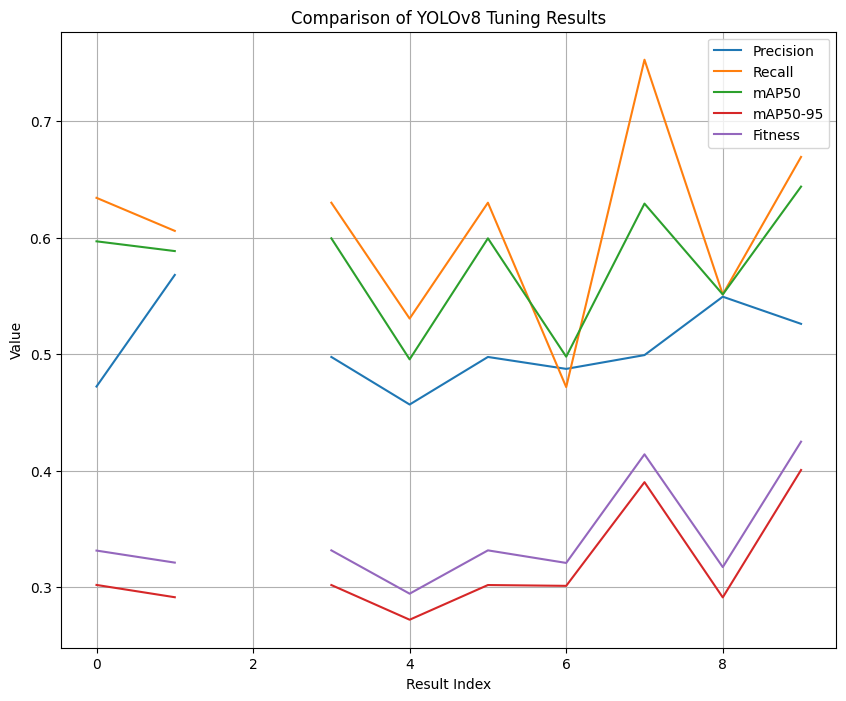

In [37]:
import matplotlib.pyplot as plt

# Setting up the plot
plt.figure(figsize=(10, 8))

# Plotting each metric
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

# Adding some plot decorations
plt.title('Comparison of YOLOv8 Tuning Results')
plt.xlabel('Result Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


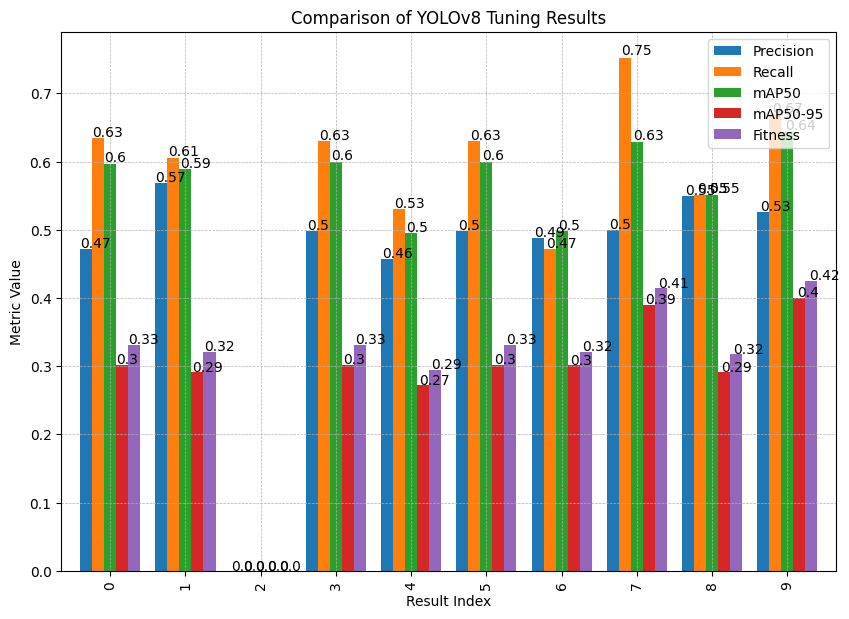

In [38]:
df_filled = df.fillna(0)  # Replace None with 0 for plotting
import matplotlib.pyplot as plt

# Plotting
ax = df_filled.plot(kind='bar', figsize=(10, 7), width=0.8)
ax.set_title('Comparison of YOLOv8 Tuning Results')
ax.set_xlabel('Result Index')
ax.set_ylabel('Metric Value')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper right')

# Adding value labels on top of each bar
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()
